In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
D_data = pd.read_csv('data/Denmark/Merged.csv')
USA_data = pd.read_csv('data/USA/filtered_USA_votes.csv')

In [17]:
D_data['opdateringsdato_x'] = pd.to_datetime(D_data['opdateringsdato_x'],errors='coerce')

start_date = "2022-12-01"
end_date = "2025-12-31"

D_data = D_data[(D_data['opdateringsdato_x'] >= start_date) & (D_data['opdateringsdato_x'] <= end_date)]

## USA Statistics Per Party

In [28]:
# Count how many voted 'Yes' (1) and 'No' (2) per (party, rollnumber)
vote_counts = USA_data.groupby(["party_code", "rollnumber", "cast_code"]).size().unstack(fill_value=0)

# Rename columns for clarity
vote_counts.columns = ["no_votes", "yes_votes"]

# Compute total votes per rollnumber per party
vote_counts["total_votes"] = vote_counts["no_votes"] + vote_counts["yes_votes"]

# Compute agreement percentage (max(yes, no) / total)
vote_counts["agreement_rate"] = vote_counts[["no_votes", "yes_votes"]].max(axis=1) / vote_counts["total_votes"]

# Compute variance and standard deviation per party
party_stats = vote_counts.groupby("party_code")["agreement_rate"].agg(["mean", "var", "std"]).reset_index()

# Display results
print(party_stats)

   party_code      mean       var       std
0         100  0.962800  0.007819  0.088426
1         200  0.910113  0.019375  0.139194


In [ ]:
# Agreement rate for each roll per party
vote_counts

no_votes  yes_votes  total_votes  agreement_rate
party_code rollnumber                                                  
100        1                212          0          212        1.000000
           2                212          0          212        1.000000
           3                212          0          212        1.000000
           4                212          0          212        1.000000
           5                212          0          212        1.000000
...                         ...        ...          ...             ...
200        1231             172         37          209        0.822967
           1232             208          1          209        0.995215
           1233             186         20          206        0.902913
           1234             172         38          210        0.819048
           1235             170         34          204        0.833333

[2470 rows x 4 columns]

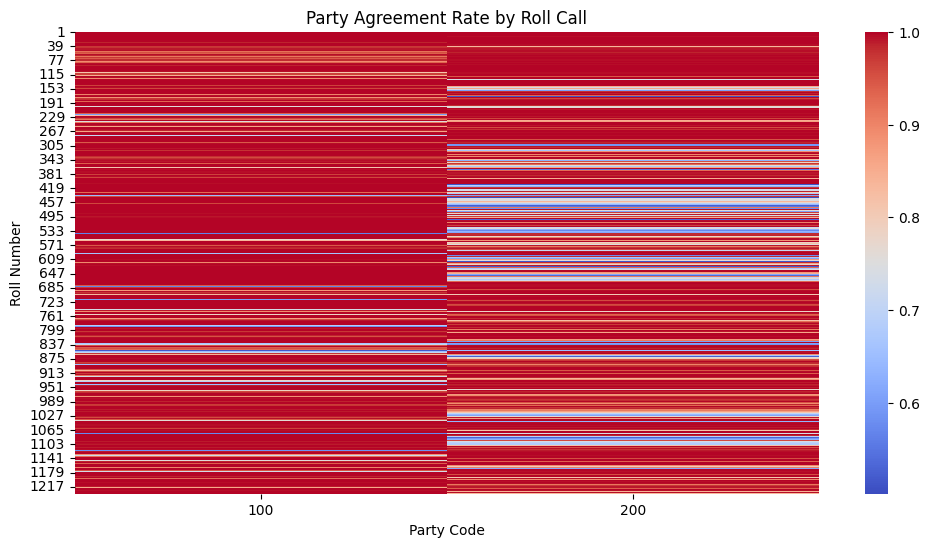

In [ ]:
# Heat map of how much they agreed for each roll
pivot_data = vote_counts.pivot_table(index="rollnumber", columns="party_code", values="agreement_rate", fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap="coolwarm", annot=False)
plt.title("Party Agreement Rate by Roll Call")
plt.xlabel("Party Code")
plt.ylabel("Roll Number")
plt.show()

In [ ]:
# Percentage of on how many votes they agreed 100%
percentage_of_total_agreement = vote_counts[vote_counts["agreement_rate"] == 1].groupby("party_code").size() / vote_counts.groupby("party_code").size()
print(percentage_of_total_agreement)

party_code
100    0.578947
200    0.363563
dtype: float64


## Danish Statistics Per Party

In [32]:
# Count how many voted 'Yes' (1) and 'No' (2) per (party, rollnumber)
vote_counts = D_data.groupby(["party", "afstemningid", "typeid_x"]).size().unstack(fill_value=0)

# Rename columns for clarity
vote_counts.columns = ["no_votes", "yes_votes"]

# Compute total votes per rollnumber per party
vote_counts["total_votes"] = vote_counts["no_votes"] + vote_counts["yes_votes"]

# Compute agreement percentage (max(yes, no) / total)
vote_counts["agreement_rate"] = vote_counts[["no_votes", "yes_votes"]].max(axis=1) / vote_counts["total_votes"]

# Compute variance and standard deviation per party
party_stats = vote_counts.groupby("party")["agreement_rate"].agg(["mean", "var", "std"]).reset_index()

# Display results
print(party_stats)

                           party      mean           var       std
0                   Alternativet  0.998846  4.662138e-04  0.021592
1                Borgernes Parti  1.000000  0.000000e+00  0.000000
2           Danmarksdemokraterne  0.984801  1.619981e-03  0.040249
3               Dansk Folkeparti  0.995850  1.347208e-03  0.036704
4    Det Konservative Folkeparti  0.998354  2.685093e-04  0.016386
5                   Enhedslisten  0.994428  1.998509e-03  0.044705
6               Liberal Alliance  0.992459  8.029276e-04  0.028336
7                    Moderaterne  0.998956  3.441852e-04  0.018552
8               Radikale Venstre  0.998952  2.879730e-04  0.016970
9              Sambandsflokkurin  1.000000  0.000000e+00  0.000000
10                        Siumut  1.000000           NaN       NaN
11             Socialdemokratiet  0.999972  8.191779e-07  0.000905
12       Socialistisk Folkeparti  0.998355  3.549467e-04  0.018840
13  Uden for folketingsgrupperne  0.919365  2.325561e-02  0.15

In [34]:
vote_counts

no_votes  yes_votes  total_votes  agreement_rate
party        afstemningid                                                  
Alternativet 9004                 2          0            2          1.0000
             9005                 3          0            3          1.0000
             9006                 3          0            3          1.0000
             9007                 3          0            3          1.0000
             9008                 3          0            3          1.0000
...                             ...        ...          ...             ...
Venstre      10110               17          0           17          1.0000
             10111               16          0           16          1.0000
             10112               17          0           17          1.0000
             10113               15          1           16          0.9375
             10114                0         16           16          1.0000

[13017 rows x 4 columns]

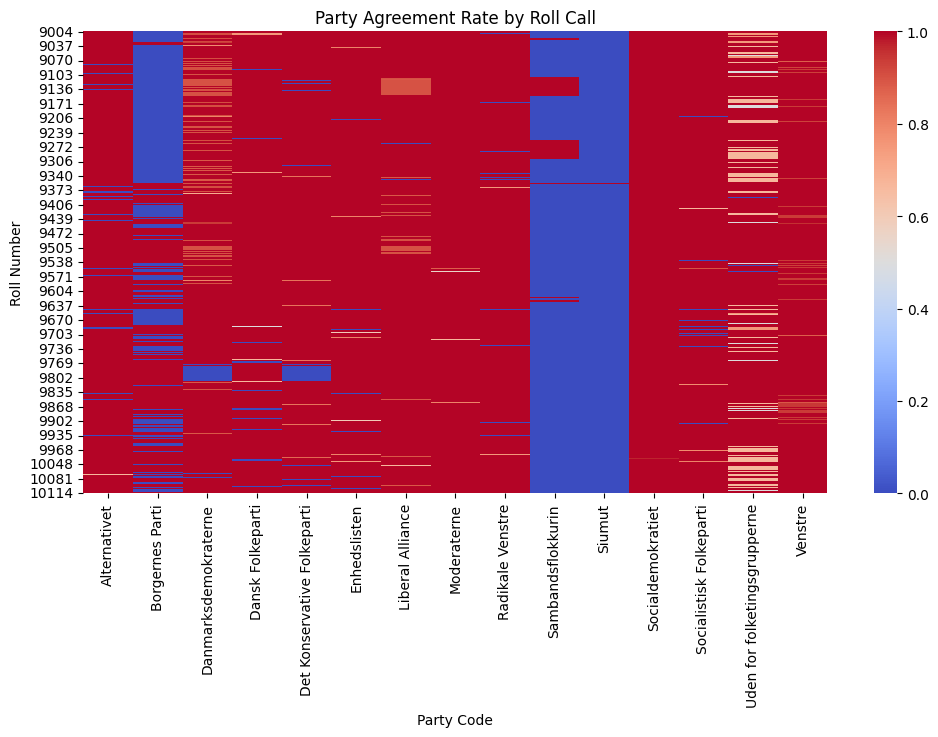

In [33]:
# Heat map of how much they agreed for each roll
pivot_data = vote_counts.pivot_table(index="afstemningid", columns="party", values="agreement_rate", fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap="coolwarm", annot=False)
plt.title("Party Agreement Rate by Roll Call")
plt.xlabel("Party Code")
plt.ylabel("Roll Number")
plt.show()

In [35]:
# Percentage of on how many votes they agreed 100%
percentage_of_total_agreement = vote_counts[vote_counts["agreement_rate"] == 1].groupby("party").size() / vote_counts.groupby("party").size()
print(percentage_of_total_agreement)

party
Alternativet                    0.997033
Borgernes Parti                 1.000000
Danmarksdemokraterne            0.854474
Dansk Folkeparti                0.986328
Det Konservative Folkeparti     0.989980
Enhedslisten                    0.982558
Liberal Alliance                0.928707
Moderaterne                     0.996212
Radikale Venstre                0.996132
Sambandsflokkurin               1.000000
Siumut                          1.000000
Socialdemokratiet               0.999053
Socialistisk Folkeparti         0.991346
Uden for folketingsgrupperne    0.772381
Venstre                         0.927083
dtype: float64
